# Optimal Parameters Discovery

## Import libraries for analysis

In [2]:
# Built-in libraries
import time

# NumPy, SciPy and Pandas
import numpy as np
import pandas as pd

# Scikit-Learn
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import sqeuclidean
from sklearn.neighbors import NearestNeighbors

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Generic settings for clustering analysis

* K-means is used in elbow method and silhouette scoring

In [3]:
ALGORITHMS = {
    'KMeans': KMeans,
    'DBSCAN': DBSCAN,
    'AgglomerativeClustering': AgglomerativeClustering,
    'GMM': GaussianMixture
}
OPTIMAL_K_ALGO = 'KMeans'
K_RANGE = range(1, 11)

## Elbow method and silhouette scoring

* Finding optimal k for k-means

In [3]:
profiles = pd.read_csv('final_profiles.csv')

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
norm_data = profiles.as_matrix()

In [6]:
X = norm_data[:, 3:3+24]

In [10]:
def get_stats_per_iter(X):
    squared_distances = []
    silhouette_values = [0]
    for k in K_RANGE:
        clusteringModel = ALGORITHMS[OPTIMAL_K_ALGO](n_clusters=k)
        clusteringModel.fit(X)
        instance_centers = list(map(lambda i: clusteringModel.cluster_centers_[i], clusteringModel.labels_))
        squared_distances.append(sum([sqeuclidean(X[j], instance_centers[j]) for j in range(X.shape[0])]) / X.shape[0])
        if k > 1:
            silhouette_avg = silhouette_score(X, clusteringModel.labels_)
            silhouette_values.append(silhouette_avg)
    return (squared_distances, silhouette_values)

In [61]:
plot_vals = []

'''Take simple random samples 5 times to save computational time'''

for i in range(5):
    start = time.time()
    input_data = X[np.random.choice(X.shape[0], X.shape[0] // 10, replace = False), :]
    plot_vals.append(get_stats_per_iter(input_data))
    print('Iteration %d: %ds elapsed' % (i+1, time.time() - start))

plot_vals = list(zip(*plot_vals))

Iteration 1: 2185s elapsed
Iteration 2: 2177s elapsed
Iteration 3: 2176s elapsed
Iteration 4: 2180s elapsed
Iteration 5: 2180s elapsed


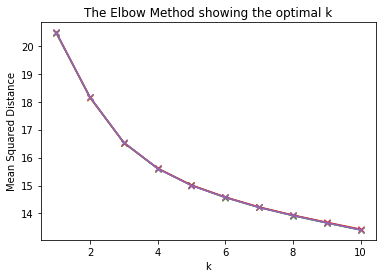

In [62]:
# Plot the elbow
for i in range(5):
    plt.plot(K_RANGE, plot_vals[0][i], 'x-')
plt.xlabel('k')
plt.ylabel('Mean Squared Distance')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('Elbow Plot (10% sample)', bbox_inches='tight')

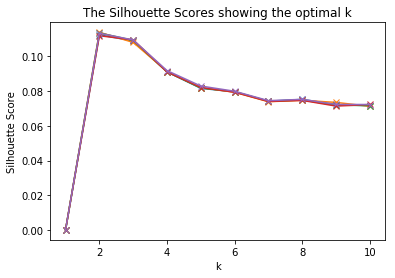

In [63]:
# Plot the silhouette scores
for i in range(5):
    plt.plot(K_RANGE, plot_vals[1][i], 'x-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('The Silhouette Scores showing the optimal k')
plt.savefig('Silhouette Plot (10% sample)', bbox_inches='tight')

## 4-th nearest neighbor method for DBSCAN

* Finding optimal eps for DBSCAN (min_pts=4)

In [4]:
# DBSCAN parameter discovery
rd_idx = np.random.choice(profiles.shape[0], 100000, replace=False)
sampled_profiles = profiles.iloc[rd_idx, 3:(3+24)].as_matrix()

nearest_neighbors = NearestNeighbors(n_neighbors=4)
start = time.time()
nearest_neighbors.fit(sampled_profiles)
nearest_distances = nearest_neighbors.kneighbors()[0][:, -1]
print('Time spent finding 4th nearest neighbor: %.4f' % (time.time()-start))
nearest_distances.sort()

Time spent finding 4th nearest neighbor: 515.4949


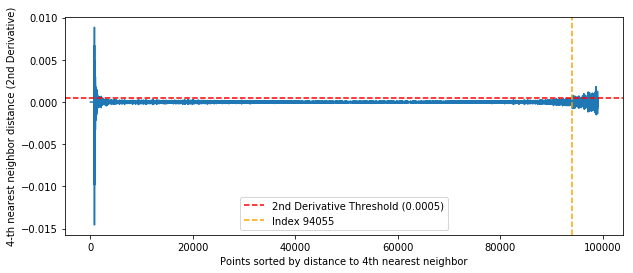

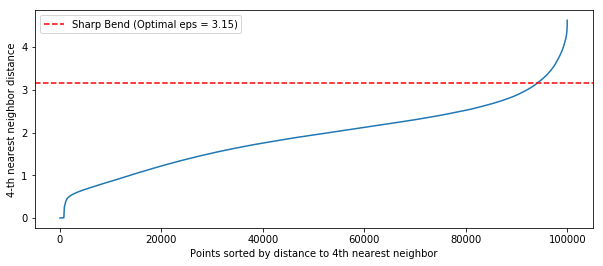

In [5]:
def df(values):
    n = len(values)
    results = []
    for i in range(n-1):
        results.append(values[i+1] - values[i])
    return results

def df2(values):
    return df(df(values))

plt.figure(figsize=(10,4))
plt.plot(df2(nearest_distances)[:-1000])
plt.xlabel('Points sorted by distance to 4th nearest neighbor')
plt.ylabel('4-th nearest neighbor distance (2nd Derivative)')
plt.axhline(y=0.0005, c='red', ls='--', label='2nd Derivative Threshold (0.0005)')
tf = [x<0.0005 for x in df2(nearest_distances)]
for i in range(len(tf)):
    if i > 20000 and not tf[i]:
        plt.axvline(x=i, c='orange', ls='--', label='Index %d' % i)
        break
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10,4))
plt.plot(nearest_distances)
plt.xlabel('Points sorted by distance to 4th nearest neighbor')
plt.ylabel('4-th nearest neighbor distance')
plt.axhline(y=nearest_distances[i], c='red', ls='--', label='Sharp Bend (Optimal eps = %.2f)' % nearest_distances[i])
plt.legend()
plt.show()
plt.close()